In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
from pprint import pprint

# scraping modules
from requests import get
from bs4 import BeautifulSoup

import unicodedata
import re
import json

from wordcloud import WordCloud

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings("ignore")

import acquire
import og_acquire
import prepare

In [2]:
plt.rc('figure', figsize=(16,8))
plt.rc('font', size=14)
sns.set_palette('pastel')

In [3]:
df = prepare.wrangle_readme_data()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231 entries, 0 to 230
Data columns (total 5 columns):
repo                            231 non-null object
language                        231 non-null object
readme_contents                 231 non-null object
clean_readme_contents           231 non-null object
len_of_clean_readme_contents    231 non-null int64
dtypes: int64(1), object(4)
memory usage: 9.1+ KB


In [5]:
df.head()

,repo,language,readme_contents,clean_readme_contents,len_of_clean_readme_contents
0,rdpeng/ProgrammingAssignment2,R,### Introduction\n\nThis second programming as...,introduction second programming assignment req...,332
1,octocat/Spoon-Knife,HTML,### Well hello there!\n\nThis repository is me...,well hello repository meant provide example fo...,62
2,tensorflow/tensorflow,C++,"<div align=""center"">\n <img src=""https://www....",div aligncenter srchttpswwwtensorfloworgimages...,434
3,SmartThingsCommunity/SmartThingsPublic,Groovy,# SmartThings Public GitHub Repo\n\nAn officia...,smartthings public github repo official list s...,32
4,twbs/bootstrap,JavaScript,"<p align=""center"">\n <a href=""https://getboot...",p aligncenter hrefhttpsgetbootstrapcom srchttp...,567


## Distribution of languages used

In [6]:
df_lang_count = pd.DataFrame(df.language.value_counts())

Total Observations

In [7]:
# 231 total observation
df_lang_count.sum()

language    231
dtype: int64

#### Seems a bit sparse on some of the languages with less than 5 projects done in that language, deciding to lop all of the languages less than 5 into a bin labeled 'other' 

In [8]:
df_lang_count

,language
JavaScript,51
Java,36
Python,27
C++,16
HTML,14
Jupyter Notebook,11
C,10
Go,10
TypeScript,9
PHP,9


We're creating this function that will remove all languages with less than 5 readme's and convert those into a observation titled 'others'.

> **the languages included in 'others':
Shell, R, Vue, Groovy, Kotlin, Powershell, Rust, C#, ApacheConf, Objective-C, Scala, TeX, Dart, & Rascal**

In [9]:
def get_others(df):
    '''
    input pandas series with value counts, convert it into a dataframe 
    to get new dataframe with dataframe with others category which is the 
    sum of the data past the first 13 rows
    '''
    df.reset_index()
    df2 = df[12:].sum()
    df2 = pd.DataFrame(df2).reset_index()
    df2 = df2.rename(columns={0:'language'})
    df = df.append(df2)
    df = df.drop(columns=(['index']))
    df = df.rename(index={0:'other'})
    df = df.sort_values(by='language', ascending=False)
    data = df.iloc[:13]
    return data

In [10]:
df_lang_count = get_others(df_lang_count)

In [11]:
df_lang_count.sum()

language    231
dtype: int64

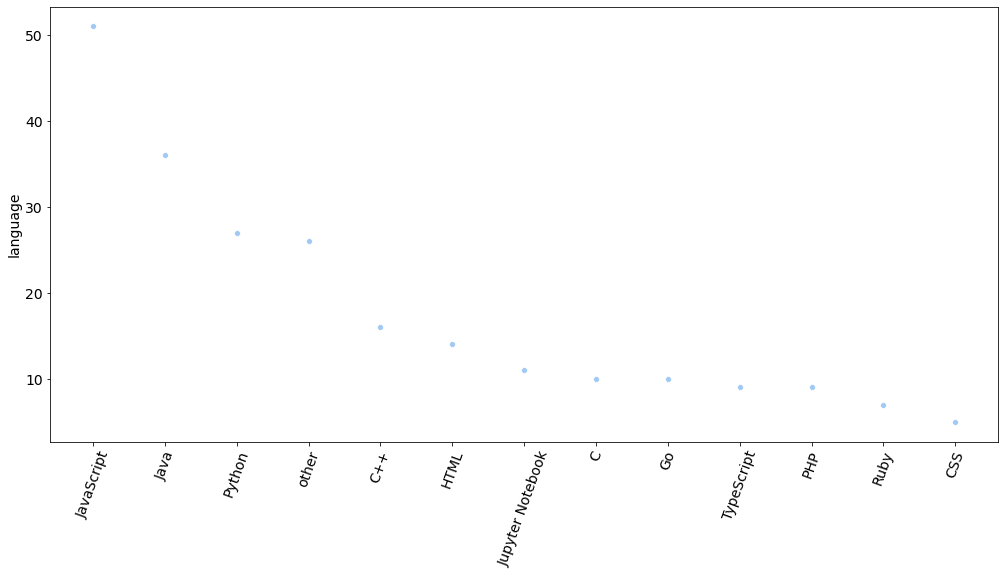

In [12]:
plt.figure(figsize=(17,8))
x = df_lang_count.index
y = df_lang_count.language
sns.scatterplot(data=df_lang_count, x=x, y=y)
plt.xticks(rotation=70)

plt.show()

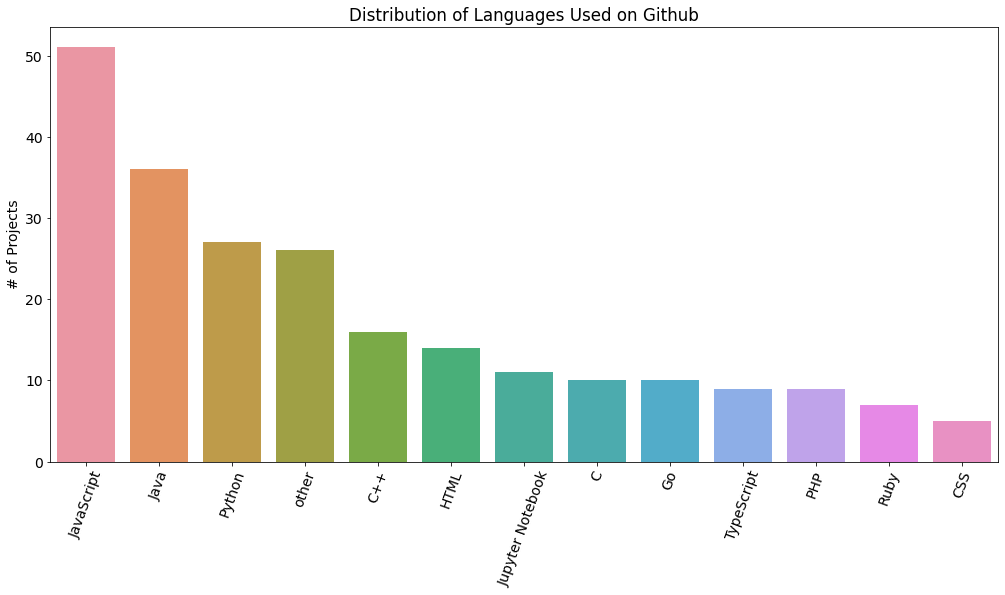

In [13]:
plt.figure(figsize=(17,8))
x = df_lang_count.index
y = df_lang_count.language
sns.barplot(data=df_lang_count, x=x, y=y)

plt.title("Distribution of Languages Used on Github")
plt.ylabel('# of Projects')

plt.xticks(rotation=70)
plt.show()

## exploring words used

Simple function to clean, remove spaces, and add them to a list for further exploration

In [14]:
def clean(text: str) -> list:
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english')
    text = (text.encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split() # tokenization
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

implementing the clean function

In [15]:
df_clean = clean(' '.join(df.readme_contents))

In [16]:
df_clean

['introduction',
 'second',
 'programming',
 'assignment',
 'require',
 'write',
 'r',
 'function',
 'able',
 'cache',
 'potentially',
 'timeconsuming',
 'computation',
 'example',
 'taking',
 'mean',
 'numeric',
 'vector',
 'typically',
 'fast',
 'operation',
 'however',
 'long',
 'vector',
 'may',
 'take',
 'long',
 'compute',
 'mean',
 'especially',
 'computed',
 'repeatedly',
 'eg',
 'loop',
 'content',
 'vector',
 'changing',
 'may',
 'make',
 'sense',
 'cache',
 'value',
 'mean',
 'need',
 'looked',
 'cache',
 'rather',
 'recomputed',
 'programming',
 'assignment',
 'take',
 'advantage',
 'scoping',
 'rule',
 'r',
 'language',
 'manipulated',
 'preserve',
 'state',
 'inside',
 'r',
 'object',
 'example',
 'caching',
 'mean',
 'vector',
 'example',
 'introduce',
 'operator',
 'used',
 'assign',
 'value',
 'object',
 'environment',
 'different',
 'current',
 'environment',
 'two',
 'function',
 'used',
 'create',
 'special',
 'object',
 'store',
 'numeric',
 'vector',
 'cache',
 'm

A wordcloud  depicting the most commonly used words among all Github projects observed

(-0.5, 1199.5, 899.5, -0.5)

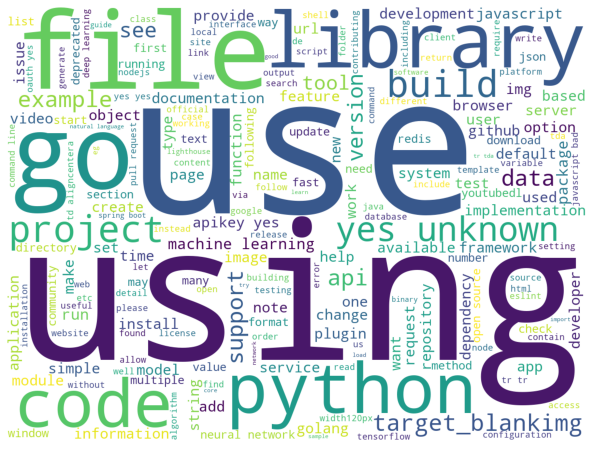

In [17]:
text = ' '.join(df_clean)
wc = WordCloud(background_color='white', width=1200, height=900)
img = wc.generate(text)

plt.imshow(img)
plt.axis('off')

## 25 most common words in readme


In [18]:
common_words = pd.Series(df_clean).value_counts()
common_words.sort_values().tail(25)

javascript     413
test           416
machine        432
example        436
version        443
api            445
support        456
run            459
see            463
function       465
install        479
learning       509
1              512
unknown        533
project        546
build          570
yes            665
code           752
using          763
data           771
python         806
file           828
use            889
library       1018
go            1070
dtype: int64

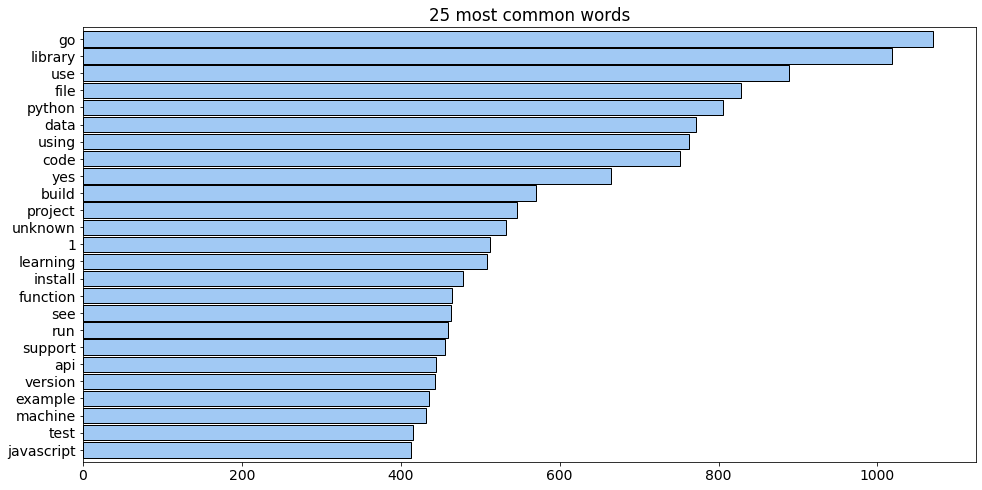

In [19]:
most_common_words = common_words.sort_values().tail(25)
most_common_words.drop(columns='all').plot.barh(width=.9, ec='black', title='25 most common words')

## Does the length of the README vary by programming language?

In [20]:
df2 = df[['language', 'readme_contents']]

In [21]:
#languages = ['Shell', 'R', 'Vue', 'Groovy', 'Kotlin', 'Powershell', 'Rust', 'C#', 'ApacheConf', 'Objective-C', 'Scala', 'TeX', 'Dart', 'Rascal']

#df2.language = df.columns.str.replace(languages, 'other')

In [22]:
df2['readme_contents'] = df2.readme_contents.apply(clean)

In [23]:
df2['length_of_readme'] = df2.readme_contents.apply(len)
df2.head()

,language,readme_contents,length_of_readme
0,R,"[introduction, second, programming, assignment...",332
1,HTML,"[well, hello, repository, meant, provide, exam...",60
2,C++,"[div, aligncenter, img, srchttpswwwtensorflowo...",430
3,Groovy,"[smartthings, public, github, repo, official, ...",32
4,JavaScript,"[p, aligncenter, hrefhttpsgetbootstrapcom, img...",568


> Scatter plot where length of readme is y-axis, x-axis is how many programming languages and hue is label of programming language

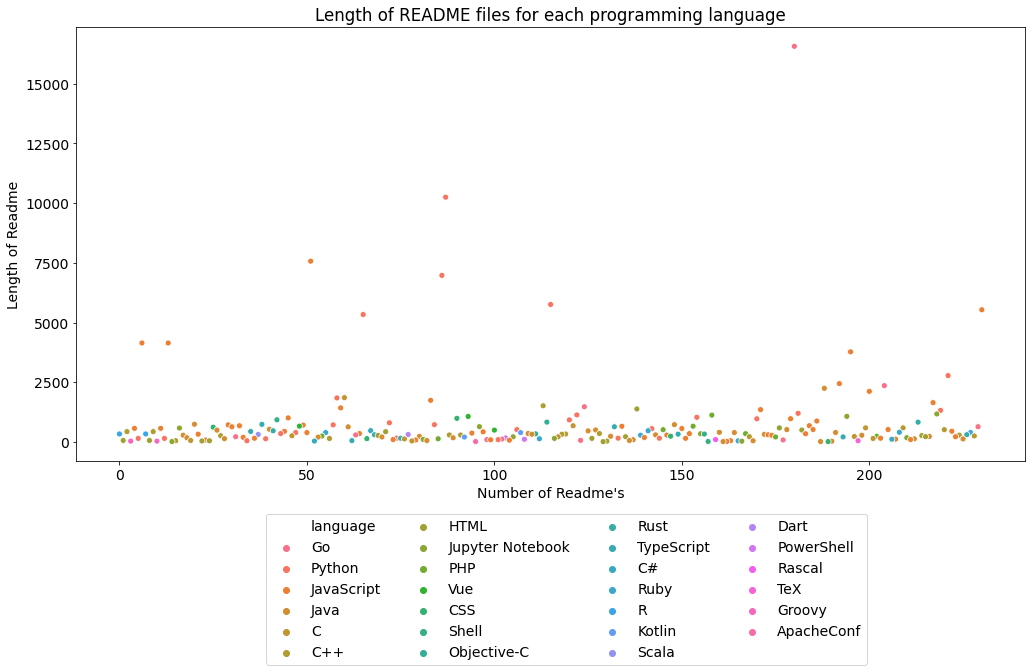

In [39]:
plt.figure(figsize=(17,8))
plt.title('Length of README files for each programming language')
x
x = df2.index
y = df2.length_of_readme
hue = df2.language
sns.scatterplot(data=df_lang_count, x=x, y=y, hue=hue)
plt.ylabel('Length of Readme')
plt.xlabel('Number of Readme\'s')

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(0.2, -0.12), loc=2, borderaxespad=0., ncol=4)

plt.show()

In [43]:
df2 = df2.sort_values(by='length_of_readme', ascending=False)

Which Languages have the longest readme's?

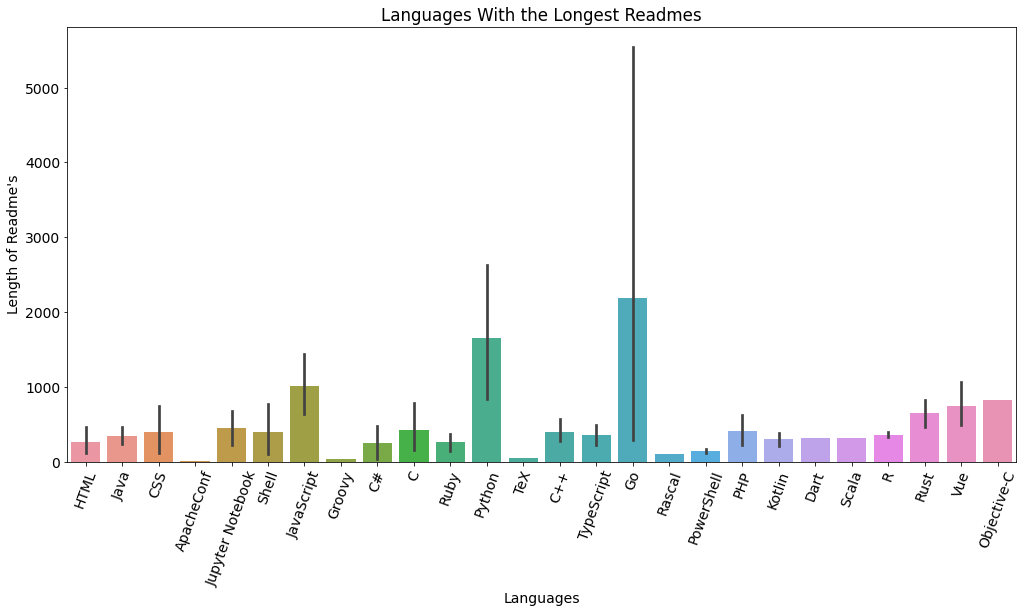

In [45]:
plt.figure(figsize=(17,8))
x = df2.language
y = df2.length_of_readme
sns.barplot(data=df_lang_count, x=x, y=y)

plt.title("Languages With the Longest Readmes")
plt.ylabel('Length of Readme\'s')
plt.xlabel('Languages')

plt.xticks(rotation=70)
plt.show()

### Word Frequency by language

In [46]:
df2.head()

,language,readme_contents,length_of_readme
129,HTML,"[devopsessentialssampleapp, simple, sample, ap...",10
187,Java,"[toy, app, exercise, repo, exercise, repositor...",13
161,Java,"[mavenproject, source, code, james, lee, jenki...",13
189,CSS,"[website, static, html, website, using, semant...",13
95,ApacheConf,"[starter, web, repo, repository, showing, git,...",14


In [55]:
df2.head()

,language,readme_contents,length_of_readme
129,HTML,"[devopsessentialssampleapp, simple, sample, ap...",10
187,Java,"[toy, app, exercise, repo, exercise, repositor...",13
161,Java,"[mavenproject, source, code, james, lee, jenki...",13
189,CSS,"[website, static, html, website, using, semant...",13
95,ApacheConf,"[starter, web, repo, repository, showing, git,...",14


In [52]:
go = clean(' '.join(df2[df2.language == 'go'].readme_contents))

In [53]:
go

[]

In [48]:
go_freq = pd.Series(go).value_counts()

In [49]:
go_freq.head()

Series([], dtype: int64)

## What does the distribution of IDFs look like for the most common words?


In [25]:
cv = CountVectorizer()
bag_of_words = cv.fit_transform(df_clean)

In [26]:
tfidf = TfidfVectorizer()
bag_of_words = tfidf.fit_transform(df_clean)

In [27]:
s_1 = pd.Series(dict(zip(tfidf.get_feature_names(), tfidf.idf_))).sort_values()

In [28]:
df3 = pd.DataFrame(bag_of_words.todense(), columns=cv.get_feature_names()).T

In [29]:
s_1.sort_values()

go                                                  6.060015
library                                             6.109786
use                                                 6.245142
file                                                6.316143
python                                              6.343040
                                                     ...    
tokenizeradd_tokensspecial_token_1                 12.343216
tokenizer_class                                    12.343216
tojson                                             12.343216
token_type_idsinputs_2token_type_ids0argmaxitem    12.343216
zyszyshttpsgithubcomzyszys                         12.343216
Length: 37200, dtype: float64

### Do different programming languages use a different number of unique words?